# EOBS seasonal means

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from warnings import warn

import cf_xarray as cfxr
import cordex as cx
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.source import get_source_collection, open_and_sort
from evaltools.utils import short_iid

dask.config.set(scheduler="single-threaded")

time_range_default = slice("1981", "2000")
xarray_open_kwargs = {"use_cftime": True, "decode_coords": "all", "chunks": None}

In [3]:
client = Client(dashboard_address="localhost:8000", threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8000/status,
Dashboard: http://127.0.0.1:8000/status,Workers: 16
Total threads: 16,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44361,Workers: 16
Dashboard: http://127.0.0.1:8000/status,Total threads: 16
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:40987,Total threads: 1
Dashboard: http://127.0.0.1:40023/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:41245,


In [ ]:
vertices = {
    "CMIP6": ("vertices_lon", "vertices_lat"),
    "CMIP5": ("lon_vertices", "lat_vertices"),
}


def add_bounds(ds, mip_era="CMIP6"):
    if "longitude" not in ds.cf.bounds and "latitude" not in ds.cf.bounds:
        ds = cx.transform_bounds(ds, trg_dims=vertices[mip_era])
        ds = ds.assign_coords(
            lon_b=cfxr.bounds_to_vertices(
                ds[vertices[mip_era][0]],
                bounds_dim="vertices",
                order="counterclockwise",
            ),
            lat_b=cfxr.bounds_to_vertices(
                ds[vertices[mip_era][1]],
                bounds_dim="vertices",
                order="counterclockwise",
            ),
        )
    return ds


def mask_with_sftlf(ds, sftlf=None):
    if sftlf is None and "sftlf" in ds:
        sftlf = ds["sftlf"]
        for var in ds.data_vars:
            if var != "sftlf":
                ds[var] = ds[var].where(sftlf > 0)
        ds["mask"] = sftlf > 0
    else:
        source = [
            ds.attrs[attr]
            for attr in ["source_id", "model_id", "source"]
            if attr in ds.attrs
        ]
        warn(f"sftlf not found in dataset: {source[0]}")
    return ds


def open_datasets(
    variables,
    frequency="mon",
    driving_source_id="ERA5",
    mask=True,
    add_missing_bounds=False,
    **kargs,
):
    catalog = get_source_collection(
        variables, frequency, driving_source_id, add_fx=["areacella", "sftlf"]
    )
    dsets = open_and_sort(
        catalog, merge=merge, concat=False, time_range=kargs.get("time_range", None)
    )
    if mask is True:
        for ds in dsets.values():
            mask_with_sftlf(ds)
    if add_missing_bounds is True:
        for dset_id, ds in dsets.items():
            if driving_source_id == "ERA5":
                dsets[dset_id] = add_bounds(ds, mip_era="CMIP6")
            elif driving_source_id == "ECMWF-ERAINT":
                dsets[dset_id] = add_bounds(ds, mip_era="CMIP5")
    return dsets


def create_cordex_grid(domain_id, mip_era="CMIP6"):
    grid = cx.domain(domain_id, bounds=True, mip_era=mip_era)
    # grid["lon"].attrs = {}
    # grid["vertices_lat"].attrs = {}
    lon_b = cfxr.bounds_to_vertices(
        grid[vertices[mip_era][0]], bounds_dim="vertices", order="counterclockwise"
    )
    lat_b = cfxr.bounds_to_vertices(
        grid[vertices[mip_era][1]], bounds_dim="vertices", order="counterclockwise"
    )
    return grid.assign_coords(lon_b=lon_b, lat_b=lat_b)


def create_regridder(source, target, method="bilinear"):
    regridder = xe.Regridder(source, target, method=method)
    return regridder


def regrid(ds, regridder):
    ds_regrid = regridder(ds)
    for var in ds.data_vars:
        if var not in ["mask", "sftlf"]:
            # continue
            ds_regrid[var] = ds_regrid[var].where(ds_regrid["mask"] > 0.0)
    return ds_regrid


def regrid_dsets(dsets, target_grid, method="bilinear"):
    for dset_id, ds in dsets.items():
        try:
            mapping = ds.cf["grid_mapping"].grid_mapping_name
        except Exception:
            print("problmes with grid_mapping definition")
            continue
        if mapping == "rotated_latitude_longitude":
            dsets[dset_id] = ds.cx.rewrite_coords(coords="all")
        else:
            print(f"regridding {dset_id} with grid_mapping: {mapping}")
            regridder = create_regridder(ds, target_grid, method=method)
            print(regridder)
            dsets[dset_id] = regrid(ds, regridder)
    return dsets


def mask_invalid(ds, vars=None, threshold=0.1):
    if isinstance(vars, str):
        vars = [vars]
    if vars is None:
        var = list(ds.data_vars)
    for var in vars:
        var_nan = ds[var].isnull().sum(dim="time") / ds.time.size
        ds[var] = ds[var].where(var_nan < threshold)
    return ds

In [5]:
def seasonal_mean(da):
    """Optimized function to calculate seasonal averages from time series of monthly means

    based on: https://xarray.pydata.org/en/stable/examples/monthly-means.html
    """
    # Get number od days for each month
    month_length = da.time.dt.days_in_month
    # Calculate the weights by grouping by 'time.season'.
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    # np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (
        (da * weights).groupby("time.season").sum(dim="time", skipna=True, min_count=1)
    )

In [21]:
mip_era = "CMIP6"
variable = "pr"
frequency = "mon"
domain = "EUR-11"
regridding = "bilinear"
driving_source_id = "ERA5"  # ECMWF-ERAINT/ERA5
models = [
    "ICON-CLM-202407-1-1",
    "REMO2020",
    "HCLIM43-ALADIN",
    "RACMO23E",
    "CNRM-ALADIN64E1",
]
# models = ["CCLM4-8-17", "REMO2015", "ALADIN63", "RACMO22E"]
levels = np.arange(-100, 110, 10)  #
# levels = np.arange(-8, 9, 1)
cmap = "BrBG"
# cmap = "RdBu_r"
period = slice("1990", "2000")

In [22]:
default_attrs = [
    "project_id",
    "domain_id",
    "institution_id",
    "driving_source_id",
    "driving_experiment_id",
    "driving_variant_label",
    "source_id",
    "version_realization",
    "frequency",
    "variable_id",
    "version",
]

In [23]:
# Define how to merge the files in xarray
if driving_source_id == "ERA5":
    merge = ["variable_id", "frequency"]
elif driving_source_id == "ECMWF-ERAINT":
    merge = ["variable_id", "frequency", "driving_variant_label", "version"]
default_attrs = [d for d in default_attrs if d not in merge]

In [24]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
    **{"merge": merge, "time_range": period},
)

Found: ['CNRM-ALADIN64E1', 'HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E', 'REMO2020'] for variables: ['pr']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.variable_id.version'


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/intake_esm/source.py:77: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xr.open_dataset(url, **xarray_o

Found 14 datasets
merging: CORDEX.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.v20240920
merging: CORDEX.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.v20250116
merging: CORDEX.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020.v1-r1.v20241120
merging: CORDEX.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.v20241205
merging: CORDEX.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.v20241216


In [25]:
rotated_grid = create_cordex_grid(domain, mip_era=mip_era)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

regridding CORDEX.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.v20250116 with grid_mapping: latitude_longitude
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.v20241205 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False


In [26]:
eobs = obs.eobs(variable, add_mask=False).sel(time=period)
eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)

In [27]:
# eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method=regridding, unmapped_to_nan=True)
eobs_on_rotated = regridder(eobs)

In [28]:
%%time
eobs_seasmean = seasonal_mean(eobs_on_rotated[eobs_var].sel(time=period)).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 15.11 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 1.26 s, sys: 314 ms, total: 1.58 s
Wall time: 7.71 s


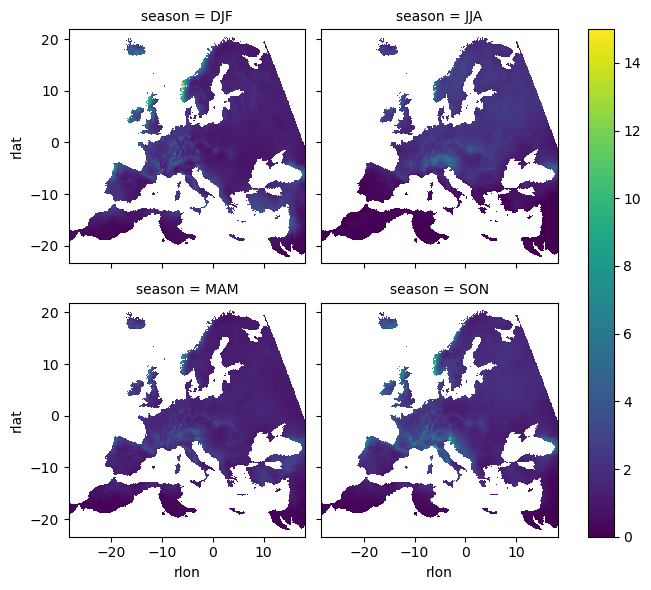

In [29]:
eobs_seasmean.plot(col="season", col_wrap=2)

In [30]:
# diffs = {
#    dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
#    - (eobs_seasmean + 273.15)
#    for dset_id, ds in dsets.items()
# }

if variable == "tas":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (eobs_seasmean + 273.15)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif variable == "pr":
    diffs = {
        dset_id: 100
        * (
            seasonal_mean(ds[[variable]].sel(time=period)).compute() * 86400
            - (eobs_seasmean)
        )
        / (eobs_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }


seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["source_id"], default_attrs=default_attrs),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:700: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  unused_keys = set(attribute.keys()) - set(inverted)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:701: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for key, value in attribute.items():
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/eval-book/lib/python3.12/site-packages/cf_xarray/accessor.py:709: FutureWarning: The return type of `Dataset.dims` will b

0 0 0 DJF ICON-CLM-202407-1-1
0 1 4 DJF REMO2020
0 2 8 DJF HCLIM43-ALADIN
0 3 12 DJF RACMO23E
0 4 16 DJF CNRM-ALADIN64E1
1 0 1 JJA ICON-CLM-202407-1-1
1 1 5 JJA REMO2020
1 2 9 JJA HCLIM43-ALADIN
1 3 13 JJA RACMO23E
1 4 17 JJA CNRM-ALADIN64E1
2 0 2 MAM ICON-CLM-202407-1-1
2 1 6 MAM REMO2020
2 2 10 MAM HCLIM43-ALADIN
2 3 14 MAM RACMO23E
2 4 18 MAM CNRM-ALADIN64E1
3 0 3 SON ICON-CLM-202407-1-1
3 1 7 SON REMO2020
3 2 11 SON HCLIM43-ALADIN
3 3 15 SON RACMO23E
3 4 19 SON CNRM-ALADIN64E1


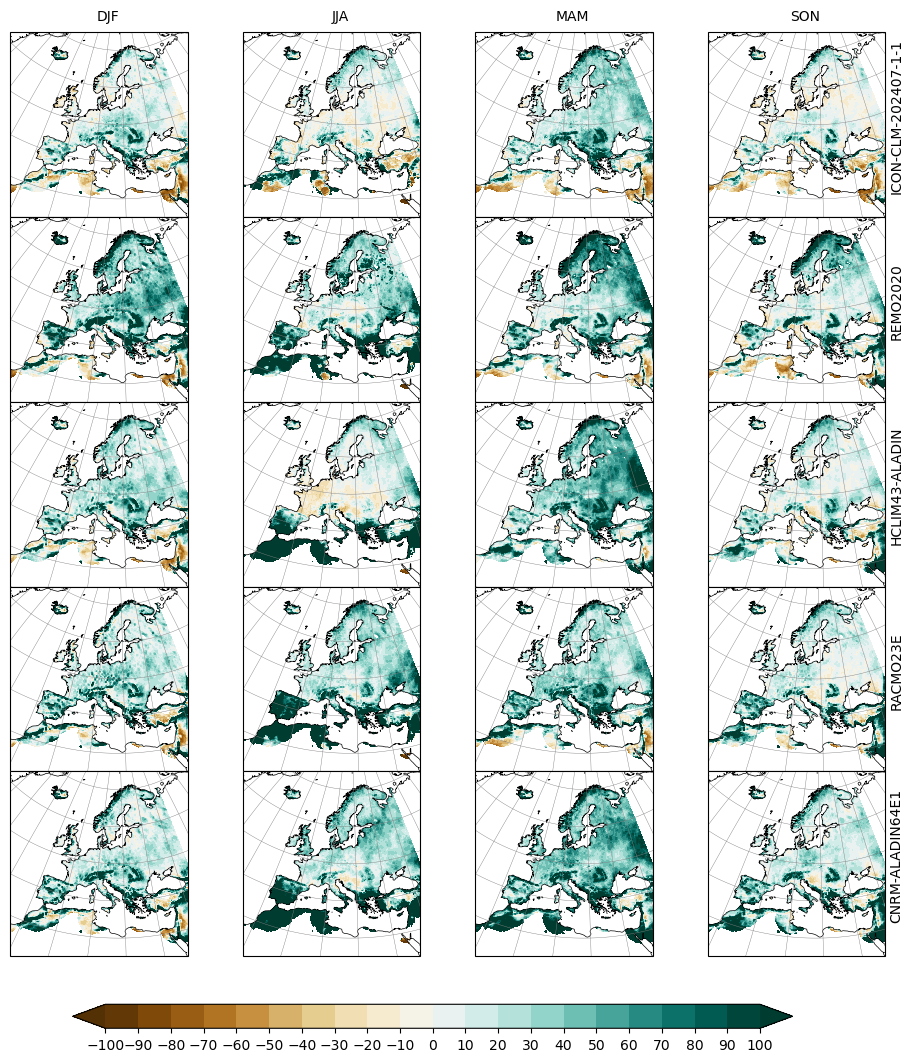

In [31]:
import numpy as np

ds = seasonal_bias.sel(dset_id=models)

# ds = seasonal_bias.copy()


nrows = ds.dset_id.size
ncols = ds.season.size

aspect = ds.cf.dims["Y"] / ds.cf.dims["X"]

# ds = diffs.where(~diffs.isnull(), drop=True)
tas = ds[variable]
# pole = ds.cf["grid_mapping"]
# transform = ccrs.RotatedPole(
#    pole_latitude=pole.grid_north_pole_latitude,
#    pole_longitude=pole.grid_north_pole_longitude,
# )
transform = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162.0)
projection = transform

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    subplot_kw={"projection": projection},
    figsize=(12, 12),
    sharex=True,
    sharey=True,
    gridspec_kw={"wspace": 0, "hspace": 0},
    #  aspect_ratio=0.97,
)

# plt.subplots_adjust(wspace=0, hspace=0)

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs = axs.flatten()

# Loop over all of the models
for i, season in enumerate(["DJF", "JJA", "MAM", "SON"]):
    for j, dset_id in enumerate(ds.dset_id.values):
        pos = i + j * ncols
        print(i, j, pos, season, dset_id)
        # Select the week 1 forecast from the specified model
        data = ds[variable].isel(season=i, dset_id=j)

        # Add the cyclic point
        # data,lons=add_cyclic_point(data,coord=ds['lon'])

        # Contour plot
        cs = axs[pos].contourf(
            ds.cf["X"],
            ds.cf["Y"],
            data,
            transform=transform,
            # Define the levels for contourf
            levels=levels,
            # cmap=cmap,
            extend="both",
            # vmin=-8, vmax=8,
            cmap=cmap,
            # norm=norm,
        )

        # if i == 3:
        #    axs[pos].set_ylabel(dset_id)

        axs[pos].set_aspect(round(aspect, 3))

        # Title each subplot with the name of the model
        # axs[pos].set_title(pos)

        # Draw the coastines for each subplot
        axs[pos].coastlines(resolution="50m", color="black", linewidth=0.5)

        gl = axs[pos].gridlines(
            draw_labels=False,
            linewidth=0.3,
            color="gray",
            xlocs=range(-180, 180, 10),
            ylocs=range(-90, 90, 10),
        )

        # axs[pos].xaxis.set_tick_position('bottom')
        # axs[pos].yaxis.set_tick_position('left')

        # Longitude labels
        # https://stackoverflow.com/questions/35479508/cartopy-set-xlabel-set-ylabel-not-ticklabels
        if i == 3:
            axs[pos].text(
                1.1,
                0.55,
                dset_id,
                va="bottom",
                ha="center",
                rotation="vertical",
                rotation_mode="anchor",
                transform=axs[pos].transAxes,
            )
        if j == 0:
            axs[pos].text(
                0.55,
                1.05,
                season,
                va="bottom",
                ha="center",
                rotation="horizontal",
                rotation_mode="anchor",
                transform=axs[pos].transAxes,
            )
        # if i == 0:
        # axs[pos].set_title(season)
        #    axs[pos].set_xlabel(dset_id)
        #    axs[pos].set_xticks(range(-180, 180, 10), crs=ccrs.PlateCarree())
        # lon_formatter = cticker.LongitudeFormatter()
        # axs[i].xaxis.set_major_formatter(lon_formatter)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        axs[pos].xaxis.set_major_formatter(lon_formatter)
        axs[pos].yaxis.set_major_formatter(lat_formatter)

        # # Latitude labels
        # axs[pos].set_yticks(range(-90, 90, 10), crs=ccrs.PlateCarree())
        # lat_formatter = cticker.LatitudeFormatter()
        # axs[i].yaxis.set_major_formatter(lat_formatter)


# Adjust the location of the subplots on the page to make room for the colorbar
# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.08, hspace=0.08)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])

# Draw the colorbar
cbar = fig.colorbar(cs, cax=cbar_ax, orientation="horizontal", ticks=levels)

plt.subplots_adjust(wspace=0, hspace=0)


# Add a big title at the top
# plt.suptitle('SubX Week 1 2m Temperature Anomalies ($^\circ$C): Apr 16, 2020 Initialized Forecasts')
plt.savefig(
    f"{mip_era}_eobs_{variable}_{period.start}-{period.stop}.pdf",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)